# Imputation time series

> Impute time series using GPFA Leaner

the goal of this notebook is to be able to:

- take a timeseries that contains gaps
- train a GPFA Learner using the available data
- impute the gap, by using the predictions of the learner
- to improve the imputation by conditioning the distribution on the other observation at the same time stamp

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#| hide
#| default_exp imputation

In [3]:
from gpfa_imputation.learner import *

import torch

import pandas as pd
from fastcore.foundation import patch

import matplotlib.pyplot as plt
import altair as alt

In [4]:
torch.manual_seed(27); # set seed for reproducibility of examples

## Fake data 

generate some fake data in order to test the imputation

What is does is:
- take a function to generate the "true" latent
- use some random coefficient to generate all the N features
- add some random noise

In [5]:
#| export
class GPFAFakeData:
    def __init__(self,
                    n_features: int,
                    n_obs: int,
                    latent_func = torch.sin, # Functions used to generate the true latent
                    noise_std = .2,
                    Lambda = None
                ):
        
        self.n_features, self.n_obs = n_features, n_obs
        self.T = torch.arange(n_obs)
        
        self.latent = latent_func(self.T)
        
        self.Lambda = torch.tensor(Lambda).reshape(n_features, 1) if Lambda is not None else torch.rand(n_features, 1)
        
        self.exact_X = (self.Lambda * self.latent).T
        
        self.X =  self.exact_X + torch.normal(0., noise_std, size = (n_obs, n_features)) 
        

In [6]:
fd = GPFAFakeData(3, 20)

In [7]:
fd_plot = pd.DataFrame(fd.X.numpy(), columns = ["x1", "x2", "x3"])
fd_plot["latent"] = pd.Series(fd.latent.numpy())

<AxesSubplot:>

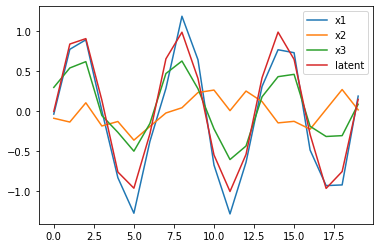

In [8]:
fd_plot.plot()

### Missing Data

add to the fake data class the ability to generate some missing data

In [9]:
# TODO add contigous missing data
@patch()
def add_missing(self: GPFAFakeData,
                prob_miss: float = .2#  Fraction of data that will be missing
               ):
    self.is_miss = torch.rand(self.n_obs) <= prob_miss
    self.X_miss = self.X[~self.is_miss]
    self.T_miss = self.T[~self.is_miss] 
    
    return self


In [10]:
fd.add_missing()

In [11]:
fd.is_miss.to(torch.float).mean() # the mean of this means should be .2

tensor(0.1500)

In [12]:
fd.X_miss.shape

torch.Size([17, 3])

In [13]:
fd.X.shape

torch.Size([20, 3])

Ideas for improving this class: add_missing should be part of the init, can get the variables with a getter func that can have a miss argument if you want the missing data or no. Otherwise another idea could be to have something the uses the pytorch dataloader api

### Save as DataFrame

In [14]:
# TODO better naming of args
@patch
def as_df(self: GPFAFakeData,
          miss = False, # full dataset (False) or the one without missing data (True)
          tidy=True, # result in tidy (long) format? 
          latent = False, # include latent as column
          add_miss = False #columns to indicate whether the row is missing or not
         ):
    
    df = pd.DataFrame(self.X.numpy(), columns = [f"x{i}" for i in range(self.n_features)])
    df["T"] = self.T
    
    if latent: df["latent"] = pd.Series(self.latent.numpy())
    
    
    id_vars = ["T"]
    
    if add_miss:
        df["is_missing"] = self.is_miss.numpy()
        id_vars.append("is_missing")
    if miss: df = df.loc[~self.is_miss.numpy(), :]

    if tidy: df = df.melt(id_vars)
    return df

In [15]:
fd.as_df()

,T,variable,value
0,0,x0,-0.033438
1,1,x0,0.775865
2,2,x0,0.894718
3,3,x0,0.008605
4,4,x0,-0.827618
5,5,x0,-1.271534
6,6,x0,-0.374269
7,7,x0,0.287415
8,8,x0,1.188889
9,9,x0,0.645823


In [16]:
fd.as_df(miss=True)

,T,variable,value
0,0,x0,-0.033438
1,1,x0,0.775865
2,2,x0,0.894718
3,3,x0,0.008605
4,4,x0,-0.827618
5,5,x0,-1.271534
6,6,x0,-0.374269
7,7,x0,0.287415
8,9,x0,0.645823
9,10,x0,-0.669665


In [17]:
fd.as_df(tidy=False)

,x0,x1,x2,T
0,-0.033438,-0.085330,0.300104,0
1,0.775865,-0.132518,0.542751,1
2,0.894718,0.107754,0.621879,2
3,0.008605,-0.181798,-0.051052,3
4,-0.827618,-0.125818,-0.260959,4
5,-1.271534,-0.359021,-0.496414,5
6,-0.374269,-0.187095,-0.150432,6
7,0.287415,-0.019440,0.473261,7
8,1.188889,0.045758,0.629526,8
9,0.645823,0.235761,0.283783,9


In [18]:
fd.as_df(latent=True)

,T,variable,value
0,0,x0,-0.033438
1,1,x0,0.775865
2,2,x0,0.894718
3,3,x0,0.008605
4,4,x0,-0.827618
...,...,...,...
75,15,latent,0.650288
76,16,latent,-0.287903
77,17,latent,-0.961397
78,18,latent,-0.750987


In [19]:
fd.as_df(add_miss=True)

,T,is_missing,variable,value
0,0,False,x0,-0.033438
1,1,False,x0,0.775865
2,2,False,x0,0.894718
3,3,False,x0,0.008605
4,4,False,x0,-0.827618
5,5,False,x0,-1.271534
6,6,False,x0,-0.374269
7,7,False,x0,0.287415
8,8,True,x0,1.188889
9,9,False,x0,0.645823


The export as a dataframe is working correctly with the missing data

In [20]:
fd_df = fd.as_df()

In [21]:
alt.Chart(fd_df).mark_line(point=True).encode(
    x = "T",
    y = "value",
    color = "variable"
)

alt.Chart(...)

In [22]:
alt.Chart(fd.as_df(miss=True)).mark_line(point=True).encode(
    x = "T",
    y = "value",
    color = "variable"
)

alt.Chart(...)

## GPFA Imputation

This is the core class that does the imputation using a GPFA

The inputs are:

- a dataframe containing the observed data, where the row with missing data have been removed
- a vector of times where the data is missing

it returns:

- a complete dataframe with the prediction of the model

In [23]:
#| export
class GPFAImputation:
    def __init__(
        self,
        data: pd.DataFrame , #observed data with gaps due to missing data. Columns "T" is the time
        T # vector of time where the data is observed + data is missing
    ):
        self.data = data
        
        self.learner = GPFALearner(torch.tensor(self.data.drop("T", axis=1).to_numpy()), torch.tensor(self.data["T"].to_numpy()))

        self.T = T
        
    def predict(self,
               tidy = True, # return prediction in tidy format or raw prediction
               ):
        self.learner.train()
        self.pred = self.learner.predict(self.T)
        
        self._tidy_pred() if tidy else self.pred
        
    def _tidy_pred(self):
        """ transform the pred output into a tidy dataframe suitable for plotting"""
        feature_names = self.data.columns.drop("T")

        pred_mean = pd.DataFrame(self.pred.mean, columns = feature_names).assign(T = self.T).melt("T", value_name="mean")
        pred_std = pd.DataFrame(self.pred.std, columns = feature_names).assign(T = self.T).melt("T", value_name="std")
        
        pred = pd.merge(pred_mean, pred_std, on=['T', 'variable'])        
        
        self.pred_tidy = pred 
        return pred 
    

In [24]:
fd = GPFAFakeData(2, 10, Lambda=[1,2.]).add_missing(.3)

imp = GPFAImputation(fd.as_df(miss = True, tidy=False), fd.T)

### Prediction plot

In [25]:
pred = imp.predict()

/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution
/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/torch/autograd/__init__.py:173: UserWarning: operator() profile_node %840 : int[] = prim::profile_ivalue(%838)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  Variable._execution_engine.run_backward(  # Calls into the C++ eng

In [29]:
@patch()
def plot_pred(
    self: GPFAImputation,
    truth = None # Optional true data to be plotted agaist predictions
):
    
    if not hasattr(self, "pred_tidy"): self.predict()
    
    error = alt.Chart(self.pred_tidy).mark_errorband().encode(
        x = "T",    
        y = alt.Y("err_low:Q", title=""),
        y2 = "err_high:Q",
        color="variable"
    ).transform_calculate(
        err_low = "datum.mean - 2 * datum.std",
        err_high = "datum.mean + 2 * datum.std"
    )

    pred = alt.Chart(self.pred_tidy).mark_line().encode(
        x = "T",    
        y = alt.Y("mean:Q", title="value variable"),
        color="variable"
    )

    plot = error + pred
    
    if truth is not None:
        
        truth_plt = alt.Chart(truth).mark_point().encode(
            x = "T",
            y = alt.Y("value", title="value variable"),
            color="variable",
            shape = "is_missing"
        )
        
        plot = plot + truth_plt
    
    
    return plot

In [30]:
imp.plot_pred(fd.as_df(miss=False, add_miss=True))

alt.LayerChart(...)

check the code works without true values

In [31]:
imp.plot_pred()

alt.LayerChart(...)

The code is running correctly and as expected around the missing data point the error is band is wider

In [32]:
#| hide
from nbdev import nbdev_export
nbdev_export()